# Лабораторная работа № 3 Ершов

__Задание:__

*B0 (базовый вариант). Список заданий:*

* *Сгенерировать бинарную маску локальных изменений*
* *Сгенерировать составные изображения из по-разному сжатых JPEG-изображений (одно произвольное сочетание $QF_{1.1}$, $QF_{1.2}$ и $QF_2$)*

* *Автоматически сформировать маску изменений по одному произвольному ДКП-коэффициенту. При этом нельзя использовать информацию об истинных значениях $QF_{1.1}$, $QF_{1.2}$ и $QF_2$. Сделать это можно разными способами: качественными или не очень*

* *Выбрать меру оценивания качества построения маски изменений и произвести оценивание*

In [64]:
# Подключаем директорию картинок
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# установка необходимых библиотек
!sudo apt-get install libmagickwand-dev
!pip install --no-cache-dir \
    opencv-python-headless==4.6.*\
    rawpy==0.17.* \
    pandas \
    Pillow==7.1.2 \
    scikit-image==0.16.2 \
    scipy==1.5.0 \
    tqdm \
    Wand

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.10.23+dfsg-2.1ubuntu11.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
# скачивание репозитория архивом
!curl -L -o master.zip http://github.com/andreacos/BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation/zipball/master/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.5M    0 10.5M    0     0  6540k      0 --:--:--  0:00:01 --:--:-- 13.0M


In [31]:
# Распаковка архива и изменение названия
!unzip master.zip
!rm master.zip
!mv andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209 repo
# !sudo rm -rf folderName

Archive:  master.zip
b4bd209595c1dbd27841c47314a3a1b3af576f7d
   creating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/README.md  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/batch.py  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/configuration.py  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/datasets.py  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/densenet.py  
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/localization.py  
   creating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/models/
  inflating: andreacos-BoostingCNN-Jpeg-Primary-Quantization-Matrix-Estimation-b4bd209/models/model_QF1_55-98_QF2_80-2-term-loss.h5  
  inflating

In [66]:
# необходимые библиотеки
import os
import io
import sys
import glob

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.util import view_as_windows
from PIL import Image

from typing import Any, Dict, List, Optional, Tuple, Union

%matplotlib inline

In [33]:
# Установим путь к репозиторию
sys.path.insert(1, '/content/repo')

In [34]:
!pwd

/content


In [35]:
!ls

drive  repo  sample_data


## Импортируем модули (localization, configuration utils, networks) из репозитория

In [36]:
"""
    2020 Department of Information Engineering and Mathematics, University of Siena, Italy.
    Authors:  Andrea Costanzo (andreacos82@gmail.com) and Benedetta Tondi
    This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public
    License as published by theFree Software Foundation, either version 3 of the License, or (at your option) any later
    version. This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the
    implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for
    more details. You should have rec   eived a copy of the GNU General Public License along with this program.
    If not, see <http://www.gnu.org/licenses/>.
    If you are using this software, please cite:
    Boosting CNN-based primary quantization matrix estimation of double JPEG images via a classification-like architecture}, 
    Benedetta Tondi and Andrea Costanzo and Dequ Huang and Bin Li
    ArXiv preprint: https://arxiv.org/abs/2012.00468
"""

# ----------------------------------------------------------------------------------------------
# Parameters for dataset creation
# ----------------------------------------------------------------------------------------------

rgb = True                     # If TRUE, coefficients come from Y channel in YCbCr, if FALSE from grayscale
block_size = (64, 64)          # Image size for the whole training / testing process
max_blocks_img = 100           # Number of blocks that are created for each image

file_ext = '.TIF'              # File format for input images (RAISE8K has only TIFF images)
make_train = False             # If FALSE, train dataset is not created (useful for testing new QF pairs)
make_test = True               # If FALSE, test dataset is not created


# ----------------------------------- RAISE ----------------------------------------

# This is the starting folder, from which Train and Test datasets are created
input_train_dir = '/media/hdddati1/Datasets/RAISE8Ksplit/Train'
input_test_dir = '/media/hdddati1/Datasets/RAISE8Ksplit/Test'

# This is the output folder where Train and Test datasets are created
out_train_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/ManyQ/Aligned/Train'
out_test_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/ManyQ/Aligned/Test'

# These are the CSV used to train and test the model. They live in out_train_dir and out_test_dir
training_csv = 'train_many_qf1_qf2_90.csv'
test_csv = 'test_many_qf1_qf2_90.csv'

# ----------------------------------- DRESDEN ----------------------------------------

# This is the starting folder, from which Train and Test datasets are created
# input_train_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/DRESDEN/Train'
# input_test_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/DRESDEN/Test'

# This is the output folder where Train and Test datasets are created
# out_train_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/ManyQ/DRESDEN/Train'
# out_test_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/ManyQ/DRESDEN/Test'

# These are the CSV used to train and test the model. They live in out_train_dir and out_test_dir
# training_csv = 'train_DRESDEN_many_qf1_qf2_90.csv'
# test_csv = 'test_DRESDEN_many_qf1_qf2_90.csv'


# ----------------------------------- PHOTOSHOP ----------------------------------------

# This is the starting folder, from which Train and Test datasets are created
# input_train_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/PHOTOSHOP/Train'
# input_test_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/PHOTOSHOP/Test'

# This is the output folder where Train and Test datasets are created
# out_train_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/ManyQ/PHOTOSHOP/Train'
# out_test_dir = '/media/hdddati1/Datasets/DeepQuantiFinder/ManyQ/PHOTOSHOP/Test'

# These are the CSV used to train and test the model. They live in out_train_dir and out_test_dir
# training_csv = 'train_PHOTOSHOP_qf1_qf2_90.csv'
# test_csv = 'test_PHOTOSHOP_qf1_qf2_90.csv'


# ----------------------------------------------------------------------------------------------
# JPEG parameters
# ----------------------------------------------------------------------------------------------
software = 'python-opencv'              # Software used for JPEG compression
force_jpeg_aligned = False              # If TRUE, only aligned JPEG patches are created
force_jpeg_misaligned = False
zig_zag_order = True                    # If TRUE, JPEG coefficients are always in zig-zag order

# First case-study QF2 = 90
# q_factors = [(60, 90), (65, 90), (70, 90), (75, 90), (80, 90), (85, 90), (90, 90), (95, 90), (98, 90)]

# Second case-study QF2 = 80
# q_factors = [(55, 80), (60, 80), (65, 80), (70, 80), (75, 80), (80, 80), (85, 80), (90, 80), (95, 80)]

# For ALL QF_1 and QF_2 = 90 setup
q_factors = [(60, 90), (61, 90), (62, 90), (63, 90), (64,  90), (65, 90), (66, 90), (67, 90), (68, 90), (69, 90),
             (70, 90), (71, 90), (72, 90), (73, 90), (74,  90), (75, 90), (76, 90), (77, 90), (78, 90), (79, 90),
             (80, 90), (81, 90), (82, 90), (83, 90), (84,  90), (85, 90), (86, 90), (87, 90), (88, 90), (89, 90),
             (90, 90), (91, 90), (92, 90), (93, 90), (94,  90), (95, 90), (96, 90), (97, 90), (98, 90)]


#q_factors = [(60, 92), (61, 92), (62, 92), (63, 92), (64,  92), (65, 92), (66, 92), (67, 92), (68, 92), (69, 92),
#             (70, 92), (71, 92), (72, 92), (73, 92), (74,  92), (75, 92), (76, 92), (77, 92), (78, 92), (79, 92),
#             (80, 92), (81, 92), (82, 92), (83, 92), (84,  92), (85, 92), (86, 92), (87, 92), (88, 92), (89, 92),
#             (90, 92), (91, 92), (92, 92), (93, 92), (94,  92), (95, 92), (96, 92), (97, 92), (98, 92)]

# For ALL QF_1 and QF_2 = 80 setup
#q_factors = [(55, 80), (56, 80), (57, 80), (58, 80), (59, 80),
#             (60, 80), (61, 80), (62, 80), (63, 80), (64, 80), (65, 80), (66, 80), (67, 80), (68, 80), (69, 80),
#             (70, 80), (71, 80), (72, 80), (73, 80), (74, 80), (75, 80), (76, 80), (77, 80), (78, 80), (79, 80),
#             (80, 80), (81, 80), (82, 80), (83, 80), (84, 80), (85, 80), (86, 80), (87, 80), (88, 80), (89, 80),
#             (90, 80), (91, 80), (92, 80), (93, 80), (94, 80), (95, 80), (96, 80), (97, 80), (98, 80)]

# PhotoShop case study QF2 = 90
# q_factors = [(7, 90), (8, 90), (9, 90), (10, 90), (11, 90), (12, 90)]

# PhotoShop case study QF2 = 80
# q_factors_ = [(7, 80), (8, 80), (9, 80), (10, 80), (11, 80), (12, 80)]

n_blocks_train = [1e5]*len(q_factors)
n_blocks_test = [1e4]*len(q_factors)

# ----------------------------------------------------------------------------------------------
# Training / Test parameters
# ----------------------------------------------------------------------------------------------

base_lr = 1e-5                         # Learning rate
max_no_Q_coefs = 15                    # Number of quantisation coefficients used for training
batch_size = 32                        # Training batch size
n_epochs = 50                          # Training epochs
scaling_factor_data = 255.0            # Input images (values [0, 255]) are scaled to [0, 1]
snapshot_frequency = 1000              # Frequency (iterations for saving training metrics)

weighted_label = False
eps_weight = 0.05
mse_weight = 0.8

In [37]:
import pandas as pd
import numpy as np
import io
from wand.image import Image
from matplotlib import pyplot as plt
import cv2
import rawpy


def read_raw(im_file):

    raw = rawpy.imread(im_file)
    rgb = raw.postprocess()

    return rgb


def read_dataset_wfilter_jpeg_grid(csv_file, qf_filter, grid_filter):

    """ Read the dataset information from input CSV with fields
        | Image paths | JPEG QF1| JPEG QF2 | Quantisation matrix array as string |
        and applies a filter to dataframe rows
        Arguments:
            csv_file    : input csv
            qf_filter   : to-be-applied filter
            grid_filter : 'aligned'/'misaligned' for images with aligned/misaligned JPEG
        Returns:
            files       : list of image paths
            labels      : list of image labels
            jpeg_pairs  : list of (QF1, QF2) for the images
    """

    assert grid_filter in ('aligned', 'misaligned')

    dataset = pd.read_csv(csv_file, sep=';', header=None,
                          names=['idx', 'filenames', 'quality1', 'quality2', 'software', 'labels', 'shift_r', 'shift_c'])

    # Filter rows by (QF1, QF2)
    isQF1 = dataset['quality1'] == qf_filter[0]
    isQF2 = dataset['quality2'] == qf_filter[1]
    dataset = dataset[isQF1 & isQF2]

    # Aligned JPEG: both grid shifts must be equal to 0
    if grid_filter == 'aligned':
        isRaligned = dataset['shift_r'] == 0
        isCaligned = dataset['shift_c'] == 0
        dataset = dataset[isRaligned & isCaligned]

    # Misaligned JPEG: either row or column shift must be equal to 0
    elif grid_filter == 'misaligned':
        isRaligned = dataset['shift_r'] != 0
        isCaligned = dataset['shift_c'] != 0
        dataset = dataset[isRaligned | isCaligned]

    # Read file paths, labels and jpeg pairs
    files = list(dataset['filenames'].values)
    labels = list(dataset['labels'].values)
    jpeg_pairs = list(zip(dataset['quality1'].values, dataset['quality2'].values))

    jpeg_pairs = [(None, int(x[1])) if np.isnan(x[0]) else (int(x[0]), int(x[1])) for x in jpeg_pairs]

    print('Found {} images and {} labels in {} with filter {}'.format(len(files), len(labels), csv_file, qf_filter))

    return files, labels, jpeg_pairs


def read_dataset_wfilter(csv_file, qf_filter):

    """ Read the dataset information from input CSV with fields
        | Image paths | JPEG QF1| JPEG QF2 | Quantisation matrix array as string |
        and applies a filter to dataframe rows
        Arguments:
            csv_file    : input csv
            qf_filter   : to-be-applied filter
        Returns:
            files       : list of image paths
            labels      : list of image labels
            jpeg_pairs  : list of (QF1, QF2) for the images
    """

    dataset = pd.read_csv(csv_file, sep=';', header=None,
                          names=['idx', 'filenames', 'quality1', 'quality2', 'software', 'labels', 'shift_r', 'shift_c'])

    # Filter rows by (QF1, QF2)
    isQF1 = dataset['quality1'] == qf_filter[0]
    isQF2 = dataset['quality2'] == qf_filter[1]
    dataset = dataset[isQF1 & isQF2]

    # Read file paths, labels and jpeg pairs
    files = list(dataset['filenames'].values)
    labels = list(dataset['labels'].values)
    jpeg_pairs = list(zip(dataset['quality1'].values, dataset['quality2'].values))

    jpeg_pairs = [(None, int(x[1])) if np.isnan(x[0]) else (int(x[0]), int(x[1])) for x in jpeg_pairs]

    print('Found {} images and {} labels in {} with filter {}'.format(len(files), len(labels), csv_file, qf_filter))

    return files, labels, jpeg_pairs


def read_dataset(csv_file):

    """ Read the dataset information from input CSV with fields
        | Image paths | JPEG QF1| JPEG QF2 | Quantisation matrix array as string |
        Arguments:
            csv_file    : input csv
        Returns:
            files       : list of image paths
            labels      : list of image labels
            jpeg_pairs  : list of (QF1, QF2) for the images
    """

    dataset = pd.read_csv(csv_file, sep=';', header=None,
                          names=['filenames', 'quality1', 'quality2', 'software', 'labels', 'shift_r', 'shift_c'])

    files = list(dataset['filenames'].values)
    labels = list(dataset['labels'].values)
    jpeg_pairs = list(zip(dataset['quality1'].values, dataset['quality2'].values))

    jpeg_pairs = [(None, int(x[1])) if np.isnan(x[0]) else (int(x[0]), int(x[1])) for x in jpeg_pairs]

    print('Found {} images and {} labels in {}'.format(len(files), len(labels), csv_file))
    return files, labels, jpeg_pairs


def qf1_qf2_coefficients_map(csv_file):

    """ Creates a table where to each (QF1, QF2) in the input CSV is associated the corresponding
        quantisation matrix
    Keyword arguments:
    csv_file : full path to the CSV input file
    """

    dataset = pd.read_csv(csv_file, sep=';', header=None,
                          names=['idx', 'filenames', 'quality1', 'quality2', 'software', 'labels', 'shift_r', 'shift_c'])
    df1 = dataset[['quality1', 'quality2', 'labels']]

    # Remove duplicates
    df2 = df1.drop_duplicates()

    return np.array(df2)


def find_Qmatrix_PIL(filename):

    """ Extract JPEG quantization matrix for Luma and Chroma with PIL library.
        Returns NaN if image is not JPEG one or both are not found
    Keyword arguments:
    filename : full path to the JPEG image
    """
    from PIL import Image

    if isinstance(filename, str):
        x = Image.open(filename)
    else:
        x = Image.open(io.BytesIO(filename))

    # PIL extracts quantization matrices that are not visited in zig-zag order so we must do that
    zz = np.array(jpeg_zigzag_order(8)).reshape(64)

    if len(x.quantization) == 1:
        q_luma = np.matrix(x.quantization[0])
        q_chroma = np.nan

        # Zig-zag order
        q_luma_arr = np.squeeze(np.asarray(q_luma[0]))
        q_luma = q_luma_arr[zz].reshape(8, 8)

    elif len(x.quantization) == 2:
        q_luma = np.matrix(x.quantization[0])
        q_chroma = np.matrix(x.quantization[1])

        q_luma_arr = np.squeeze(np.asarray(q_luma[0]))
        q_chroma_arr = np.squeeze(np.asarray(q_chroma[0]))

        # Zig-zag order
        q_luma = q_luma_arr[zz].reshape(8, 8)
        q_chroma = q_chroma_arr[zz].reshape(8, 8)

    return np.array(q_luma), q_chroma


def rearrange_zigzag_array(in_arr, size=8, magnify=1):

    """ Rebuilds a matrix in zig-zag order by starting from an array
    Keyword arguments:
    in_arr : input array
    size : size of the output matrix [size x size]
    magnify: the "zooming" factor of the matrix, only for looking good in figures
    """

    zigzag = np.array(jpeg_zigzag_order(size))
    arr2 = in_arr.flatten()
    assert len(arr2) <= size**2

    output = np.zeros((size, size))

    for k in range(len(arr2)):

        for i in range(size):
            for j in range(size):
                if zigzag[i, j] == k:
                    output[i, j] = arr2[k]

    return np.kron(output, np.ones((magnify, magnify)))


def jpeg_zigzag_order(n):

    """ Zig-zag reordering of [n x n] matrix
    Keyword arguments:
    n : size of the matrix to be rearranged in zig-zag order
    """

    def move(i, j):
        if j < (n - 1):
            return max(0, i - 1), j + 1
        else:
            return i + 1, j

    a = [[0] * n for _ in range(n)]
    x, y = 0, 0
    for v in range(n * n):
        a[y][x] = v
        if (x + y) & 1:
            x, y = move(x, y)
        else:
            y, x = move(y, x)
    return a


def zigzag_order_arr(matrix):

    """ Flatten a matrix in zig-zag order.
    Keyword arguments:
    matrix : input n x m matrix
    """

    assert len(matrix.shape) == 2
    n, m = matrix.shape

    ordering = [[] for i in range(n + m - 1)]
    for i in range(n):
        for j in range(m):
            s = i + j
            if s % 2 == 0:
                ordering[s].insert(0, matrix[i][j])

            else:
                ordering[s].append(matrix[i][j])

    zigzag = []
    for i in range(len(ordering)):
        for j in range(len(ordering[i])):
            zigzag.append(ordering[i][j])

    return np.array(zigzag)


def Q2string(Q):

    """ Converts a matrix to a comma separated string .
    Keyword arguments:
    Q : input matrix
    """

    sq = ''
    for x in np.array(Q).flatten():
        sq += str(x) + ','

    return sq[:-1]


def string2Q(sq, size=(8, 8), flatten=True):

    """ Converts a comma separated string to a matrix.
    Keyword arguments:
    sq : input string
    size : output matrix size
    """

    assert len(sq.split(',')) == size[0]*size[1]

    if flatten:
        return np.array([int(x) for x in sq.split(',')]).flatten()
    else:
        return np.array([int(x) for x in sq.split(',')]).reshape(size)


def find_jpeg_quality_buf(buffer):

    """ JPEG quality estimation from buffer image data.
    Keyword arguments:
    buffer : image buffer
    """

    with Image(blob=buffer) as x:
        return int(x.compression_quality)


def find_jpeg_quality(fname):

    """ Estimate JPEG compression quality factor
    Keyword arguments:
    filename : full path to the JPEG image
    """

    if fname.split('.')[-1].lower() not in ['jpeg', 'jpg']:
        print('Input file must be JPEG!')
        return 1

    with Image(filename=fname) as x:
        return x.compression_quality


def plot_metrics(loss_array, max_iterations, exp_identifier):

    """ Plots training loss over epochs
    Keyword arguments:
    loss_array : array with training losses
    max_iterations: training iterations
    exp_identifier: figure's title
    """

    plt.close('all')
    ls = np.array(loss_array).flatten()
    # plt.plot(ls.flatten()[np.arange(0, ls.shape[0], max_iterations)], '.')
    plt.figure(figsize=(12, 9))
    plt.plot(ls.flatten(), '.')
    plt.title(exp_identifier)
    plt.grid()
    plt.ylabel('Training Loss (MSE) per coefficient')
    plt.xlabel('Iterations {:d} iters = 1 epoch'.format(max_iterations))
    plt.show()
    return


def plot_average_error(arr, savefile='mse_vs_coeffs.png'):

    """ Plots MSE (averaged over all dataset) for each estimated coefficient of the
        quantisation matrix
    Keyword arguments:
    arr : array with test MSE
    savefile: if equal to '', displays plots otherwise path to the saved plot image
    """

    fig, ax1 = plt.subplots(1, 1)
    cax1 = ax1.matshow(arr, cmap='Blues')
    ax1.set_title('Average MSE for each coefficient')
    cbar = fig.colorbar(cax1, ax=ax1, cmap='Blues', fraction=0.046, pad=0.04)

    # # Write values over matrix data
    for i in range(0, arr.shape[0]):
        for j in range(0, arr.shape[1]):
            c = arr[j][i]
            ax1.text(i, j, '{:3.2f}'.format(c), va='center', ha='center', fontsize=18)

    if savefile != '':
        plt.savefig(savefile, dpi=fig.dpi)
        plt.close(fig)
    else:
        plt.show()

    return


def plot_average_accuracy(arr, savefile='accuracy_vs_coeffs.png'):

    """ Plots exact accuracy (averaged over all dataset) for each estimated coefficient of the
        quantisation matrix
    Keyword arguments:
    arr : array with test accuracy
    savefile: if equal to '', displays plots otherwise path to the saved plot image
    """

    fig, ax1 = plt.subplots(1, 1)
    cax1 = ax1.matshow(arr, cmap='Blues')
    ax1.set_title('Average accuracy for each coefficient')
    cbar = fig.colorbar(cax1, ax=ax1, cmap='Blues', fraction=0.046, pad=0.04)

    # # Write values over matrix data
    for i in range(0, arr.shape[0]):
        for j in range(0, arr.shape[1]):
            c = arr[j][i]
            ax1.text(i, j, '{:3.2f}'.format(c), va='center', ha='center', fontsize=18)

    if savefile != '':
        plt.savefig(savefile, dpi=fig.dpi)
        plt.close(fig)
    else:
        plt.show()

    return


def assign_exp_id(qfactors, add_info, datatype='model'):
    exp_id = ''
    for qf in qfactors:
        exp_id += '{}-{}_'.format(qf[0], qf[1])
    for info in add_info:
        exp_id += '{}_'.format(info)

    return '{}_{}'.format(datatype, exp_id)[:-1]


def mse_qf1_qf2(qf1, qf2, ncoefs=6):

    """ Computes MSE for a given (QF1, QF2) pair on a given number of coefficients of
    the quantisation matrices of QF1, QF2)
    Keyword arguments:
    qf1 : first quality factor
    qf2 : second quality factor
    ncoefs: number of coefficients on which MSE is computed
    """

    dummy = np.random.randint(0, 255, (64, 64))
    buffer_1 = cv2.imencode('.jpg', dummy, [int(cv2.IMWRITE_JPEG_QUALITY), qf1])[1]
    Q1 = find_Qmatrix_PIL(buffer_1)[0]
    if zig_zag_order:
        Q1 = zigzag_order_arr(Q1)

    buffer_2 = cv2.imencode('.jpg', dummy, [int(cv2.IMWRITE_JPEG_QUALITY), qf2])[1]

    Q2 = find_Qmatrix_PIL(buffer_2)[0]
    if zig_zag_order:
        Q2 = zigzag_order_arr(Q2)

    mse = np.sum(np.square(Q1[:ncoefs] - Q2[:ncoefs])) / ncoefs
    return mse


def mse_table_qf1_qf2(step=1, ncoefs=6, printme=True):

    """ Computes MSE for all (QF1, QF2) pairs on a given number of coefficients
    Keyword arguments:
    step : sampling step for QF1 and QF2
    ncoefs: number of coefficients on which MSE is computed
    printme: if True, save an image with matrix MSEs
    """

    mse_table = np.zeros((101, 101))

    dummy = np.random.randint(0, 255, (64, 64))
    for i in range(1, 101, step):
        for j in range(1, 101, step):
            mse_table[i][j] = mse_qf1_qf2(i, j, ncoefs)

    if printme:

        fig, ax1 = plt.subplots(1, 1)
        cax1 = ax1.matshow(mse_table, cmap='viridis')
        ax1.set_title('MSE between QM coefficients of (QF1, QF2)')
        cbar = fig.colorbar(cax1, ax=ax1, cmap='Blues', fraction=0.046, pad=0.04)

        # # Write values over matrix data
        # for i in range(0, mse_table.shape[0], step):
        #     for j in range(0, mse_table.shape[1], step):
        #         c = mse_table[j][i]
        #         ax1.text(i, j, '{:3.2f}'.format(c), va='center', ha='center', fontsize=18)

        plt.savefig('mse_table.png', dpi=fig.dpi)
        plt.close(fig)
        np.save('mse_table.npy', mse_table)

    return mse_table


def plot_average_epoch_loss(loss_arr, n_epochs, exp_identifier, show=True):

    loss_arr = np.array(loss_arr)
    iter_epochs = loss_arr.shape[0] // n_epochs
    me = []
    for i in range(n_epochs):
        ls = loss_arr[i * iter_epochs:(i + 1) * iter_epochs]
        me.append(np.mean(ls))

    if show:
        plt.figure(figsize=(12, 9))
        plt.plot(np.arange(n_epochs), np.array(me), 'o-', markersize=8)
        plt.xticks(np.arange(0, n_epochs, step=10))
        plt.yticks(np.arange(0, np.max(me) + 0.5, step=0.5))
        plt.xlabel('Epoch ({:d} iterations)'.format(iter_epochs))
        plt.ylabel('Average MSE (per coefficient)')
        plt.title(exp_identifier)
        plt.grid()
        plt.show()

    return me


def check_shifts(csv_file):

    shifts = []
    with open(csv_file) as fp:

        for cnt, line in enumerate(fp):
            line = line.replace('\n', '')
            shift_r = line.split(';')[-1]
            shift_c = line.split(';')[-2]
            shift = (int(shift_c), int(shift_r))

        if shift not in shifts:
            shifts.append(shift)
            print('Found new shift: {},{}'.format(shift_c, shift_r))

    print('-'*20)
    print('Found {} shifts'.format(len(shifts)))
    print(shifts)

    return shifts


def print_mse():
    t = np.load('/results/mse_table.npy')
    print(mse_qf1_qf2(85, 88))
    return


def coefficient2label(coefficients, max_coefficients):

    """ Convert each JPEG quantisation coefficient C into a binary array where the (Cth - 1) index is set to 1 and
        all other indices are set to 0. Concatenate all the arrays into a single array that is used as training label
    Keyword arguments:
        coefficients : array of JPEG quantisation coefficients
        max_coefficients : array whose i-th element is the max value the i-th JPEG quantisation coefficient can assume
    Returns:
        A Numpy array that is the concatenation of all the quantisation coefficients labels
    """

    assert len(coefficients) == len(max_coefficients)

    # For each JPEG quantisation coefficient
    label = np.zeros(0)
    for i in range(len(max_coefficients)):

        # Init an empty array with N elements where N is the maximum value the coefficient can assume
        x = np.zeros(max_coefficients[i])

        # Set to 1 the index (subract 1 because of array 0-indexing) corresponding to the coefficient value
        x[coefficients[i]-1] = 1
        label = np.hstack((label, x))
        # print('index (zig-zag): {}; coeff: {}; label = {}'.format(i, coefficients[i], x))

    return np.array(label).flatten()


def label2coefficient(label, max_coefficients):

    """ Convert a binary array where the (Cth - 1) index is set to 1 and all other indices are set to 0 to a single
        coefficient C. Concatenate all the arrays into a single array that is used as training label
    Keyword arguments:
        label : A Numpy array that is the concatenation of all the quantisation coefficients labels
        max_coefficients : array whose i-th element is the max value the i-th JPEG quantisation coefficient can assume
    Returns:
        A Numpy array that is the quantisation coefficients
    """

    # Cumulate sub-array lengths for indexing
    y = np.concatenate(([0], np.cumsum(max_coefficients)))
    coefficients = []

    # For each "chunk" of the label array
    for i in range(len(y)-1):

        x = label[int(y[i]):int(y[i+1])]
        x[np.argmax(x)] = 1
        x[x != 1] = 0

        # Each "chunk" represents a coefficient, hence there must be only one index set to 1
        assert(len(np.argwhere(x == 1)))

        # Recover coefficient (add +1) because array is 0-indexed
        coefficients.append(np.argwhere(x == 1).flatten()[0]+1)

        # print('index (zig-zag): {}; coeff: {}; label = {}'.format(i, coefficients[-1], x))

    return np.array(coefficients).flatten()


def max_min_coefficient(quality_range=(50, 100), n_coeffs=15, zig_zag_order=True):

    """ Find maximum and minimum value for each JPEG quantisation coefficient for a given range of quality factors
    Keyword arguments:
        quality_range : minimum and maximum JPEG compression quality
        n_coeffs: the desired number of JPEG coefficients in [0, 64)
        zig_zag_order : if True, the JPEG cofficients are read in zig-zag order
    Returns:
        max_coefficients : array whose i-th element is the maximum value assumed by the i-th coefficient for the lowest
                           JPEG quality in quality_range
        min_coefficients : array whose i-th element is the minimum value assumed by the i-th coefficient for the highest
                           JPEG quality in quality_range
    """

    # Create a random uint8 matrix to compress with JPEG
    im = np.random.randint(0, 256, (100, 100))

    # Compress with both JPEG qualities
    jpeg_max_quality = cv2.imencode('.jpg', im, [int(cv2.IMWRITE_JPEG_QUALITY), quality_range[1]])[1]
    jpeg_min_quality = cv2.imencode('.jpg', im, [int(cv2.IMWRITE_JPEG_QUALITY), quality_range[0]])[1]

    # Find coefficients
    Q_high = find_Qmatrix_PIL(jpeg_max_quality)[0]
    Q_low = find_Qmatrix_PIL(jpeg_min_quality)[0]

    # Rearrange coefficients in zig-zag order (if required)
    if zig_zag_order:
        Q_high = zigzag_order_arr(Q_high)
        Q_low = zigzag_order_arr(Q_low)
    else:
        Q_low = np.reshape(Q_low, (64,))
        Q_high = np.reshape(Q_high, (64,))

    # print(Q_low[:n_coeffs])
    return Q_low[:n_coeffs], Q_high[:n_coeffs]


In [38]:
"""
    2020 Department of Information Engineering and Mathematics, University of Siena, Italy.
    Authors:  Andrea Costanzo (andreacos82@gmail.com) and Benedetta Tondi
    This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public
    License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later
    version. This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the
    implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for
    more details. You should have received a copy of the GNU General Public License along with this program.
    If not, see <http://www.gnu.org/licenses/>.
    If you are using this software, please cite:
    Boosting CNN-based primary quantization matrix estimation of double JPEG images via a classification-like architecture}, 
    Benedetta Tondi and Andrea Costanzo and Dequ Huang and Bin Li
    ArXiv preprint: https://arxiv.org/abs/2012.00468
"""

import sys
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.activations import softmax as keras_softmax
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy, mean_squared_error
import keras.backend as K



def custom_qf_loss(y_true, y_pred):

    """ Keras custom loss for QF Estimation
    :param y_true: Tensorflow/Theano tensor of predicted labels
    :param y_pred: Tensorflow/Theano tensor of true labels
    :return: Custom loss
    """
    return K.mean(K.pow(2*K.abs(y_pred - y_true), 20) / (1 + K.pow(2*K.abs(y_pred - y_true), 19)))


def custom_softmax_activation(max_vals):

    """
    Keras custom "piece-wise" softmax activation
    :param max_vals: bins for piecewise computation
    :return: custom softmax function
    """
    def custom_softmax(x):

        bins = np.concatenate(([0], np.cumsum(max_vals))).astype(np.int16)

        stack_list = []
        for i in range(0, len(bins)-1):
            stack_list.append(keras_softmax(x[:, int(bins[i]):int(bins[i + 1])]))

        return tf.concat(stack_list, axis=-1)

    return custom_softmax

#@tf.function
def custom_mse_wrapper(max_vals):

    """
    Keras custom "piece-wise" MSE metric
    :param max_vals: bins for piecewise computation
    :return: custom mse function
    """
    def custom_mse(y_true, y_pred):

        bins = np.concatenate(([0], np.cumsum(max_vals))).astype(np.int)

        mse_val = tf.constant(0, dtype=tf.float64)

        for i in range(0, len(bins) - 1):

            y_true_to_coeff = tf.argmax(y_true[:, bins[i]:bins[i+1]], 1) + 1
            y_pred_to_coeff = tf.argmax(y_pred[:, bins[i]:bins[i+1]], 1) + 1

            mse_val = tf.add(mse_val,
                             tf.reduce_sum(tf.square(y_true_to_coeff - y_pred_to_coeff)) / cfg.batch_size)
        return mse_val

    return custom_mse


# Trick to pass parameters to custom losses
def custom_categorical(max_vals):
    def custom_categorical_crossentropy(y_true, y_pred):

        """ Keras custom loss for QF Estimation with the new labeling strategy.
        Now the label is a categorical array with values [0, 1]. The length of the
        array is equal to the sum of values in max_vals, that is the maximum value
        each coefficient can assume. Index == value is set to 1. E.g., for 2 coefficients
        [6, 7] where max_length is [11, 12]:
            y_true = [0 0 0 0 0 1 0 0 0 0 0, 0 0 0 0 0 0 1 0 0 0 0 0]
        Categorical crossentropy is computed on each individual sub-label rather than on full y_true.
        Each "chunk" of loss is added to total loss
        Example:
        loss(y_true[:, 0:11], y_pred[:, 0:11]) + loss(y_true[:, 11:], y_pred[:, 11:])
        :param y_true: Tensorflow/Theano tensor of predicted labels
        :param y_pred: Tensorflow/Theano tensor of true labels
        :return: Custom loss
        """
        bins = np.concatenate(([0], np.cumsum(max_vals))).astype(np.int16)

        loss = categorical_crossentropy(y_true[:, int(bins[0]):int(bins[1])],
                                        y_pred[:, int(bins[0]):int(bins[1])])
        for i in range(1, len(bins) - 1):
            loss = tf.add(loss, categorical_crossentropy(y_true[:, int(bins[i]):int(bins[i + 1])],
                                                         y_pred[:, int(bins[i]):int(bins[i + 1])]))

        return loss

    return custom_categorical_crossentropy

#@tf.function
def custom_two_terms_loss_wrapper(max_vals, c=0.8):
    def custom_two_terms_loss(y_true, y_pred):

        """ Keras custom loss for QF Estimation with the new labeling strategy.
        Now the label is a categorical array with values [0, 1]. The length of the
        array is equal to the sum of values in max_vals, that is the maximum value
        each coefficient can assume. Index == value is set to 1. E.g., for 2 coefficients
        [6, 7] where max_length is [11, 12]:
            y_true = [0 0 0 0 0 1 0 0 0 0 0, 0 0 0 0 0 0 1 0 0 0 0 0]
        Categorical crossentropy is computed on each individual sub-label rather than on full y_true.
        Each "chunk" of loss is added to total loss
        Example:
        loss(y_true[:, 0:11], y_pred[:, 0:11]) + loss(y_true[:, 11:], y_pred[:, 11:])
        :param y_true: Tensorflow/Theano tensor of predicted labels
        :param y_pred: Tensorflow/Theano tensor of true labels
        :return: Custom loss
        """
        bins = np.concatenate(([0], np.cumsum(max_vals))).astype(np.int)
        batch_size = batch_size

        loss_1 = tf.zeros(shape=(batch_size,), dtype=tf.float32)
        loss_2 = tf.zeros(shape=(batch_size,), dtype=tf.float32)

        # For each "segment" of the predicted label / ground truth
        for i in range(0, len(bins) - 1):

            # First term of the loss
            cce = categorical_crossentropy(y_true[:, bins[i]:bins[i + 1]],
                                           y_pred[:, bins[i]:bins[i + 1]])
            # Add to total
            loss_1 = tf.add(loss_1, cce)

            # Second term of the loss
            # Create a tensor with index position e.g. [0, 1, 2, ... , 15] repeated for all batch
            ind_arr_i = tf.cast(tf.range(int(max_vals[i])), dtype=tf.float32)
            batch_ind_i = tf.repeat(tf.reshape(ind_arr_i, (1, int(max_vals[i]))), batch_size, 0)

            # Find where the ground truth segment is equal to 1.0 (once per segment by construction)
            y_true_i = tf.cast(y_true[:, bins[i]:bins[i+1]], dtype=tf.float32)
            v_i = tf.where(tf.equal(y_true_i, tf.constant(1, dtype=tf.float32)))

            # Reshape the information to be compliant with the batch structure
            v_i = tf.cast(tf.repeat(tf.reshape(v_i[:, 1], (batch_size, 1)), int(max_vals[i]), 1), tf.float32)

            # Batch-wise squared distance from each index to the index where ground truth is 1.0
            delta_sq_i = tf.square(tf.subtract(batch_ind_i, v_i))

            # Batch_wise sum over all distances
            custom_term = tf.reduce_sum(tf.multiply(y_pred[:, bins[i]:bins[i+1]], delta_sq_i), 1)

            loss_2 = tf.add(loss_2, custom_term)

        # Weighted loss
        loss = tf.add(tf.scalar_mul(c, loss_1), tf.scalar_mul((1-c), loss_2))

        # Print / save individual loss terms here. Can't return multiple outputs
        tot_loss = tf.reduce_mean(loss)
        tot_loss_1 = tf.reduce_mean(loss_1)
        tot_loss_2 = tf.reduce_mean(loss_2)
        tf.print('Loss: ', tot_loss, 'First term: ', tot_loss_1, 'Second term: ', tot_loss_2, output_stream=sys.stdout)
        '''log = ' Loss = {:.4f}; term_1 = {:.4f}; term_2 = {:.4f}'\
                  .format(tf.keras.backend.eval(tf.reduce_mean(loss)),
                          tf.keras.backend.eval(tf.reduce_mean(loss_1)),
                          tf.keras.backend.eval(tf.reduce_mean(loss_2)))
        # tf.print(log[0], output_stream=sys.stdout)
        with open('loss_terms.log', 'a') as loss_log:
            loss_log.write(log[0].replace(' Loss = ', '')
                                 .replace(' term_1 = ', '')
                                 .replace(' term_2 = ', '') + '\n')'''

        return loss

    return custom_two_terms_loss


def normalised_mean_squared_error(y_true, y_pred):
    """ Keras custom loss: Normalised Mean Squared Error
    :param y_true: Tensorflow/Theano tensor of predicted labels
    :param y_pred: Tensorflow/Theano tensor of true labels
    :return: Normalised Mean Squared Erro
    """
    return K.mean(K.square(y_pred - y_true) / K.square(y_true), -1)


def change_last_layer_nclasses(model, num_classes, freeze=False):

    """ Changes last (Dense) layer of ContrastNet for transfer learning
    Args:
       model: ContrastNet model.
       num_classes: number of new output classes
    Returns:
       New Keras sequential model.
    """

    for layer in model.layers:
        layer.trainable = not freeze

    # define a new output layer to connect with the last fc layer in vgg
    x = model.layers[-2].output
    new_output_layer = Dense(num_classes, activation='relu', name='predictions')(x)

    # combine the original VGG model with the new output layer
    new_model = Model(inputs=model.input, outputs=new_output_layer)

    return new_model


def contrastNet(in_shape=(64, 64, 3), num_classes=2, nf_base=64, layers_depth=(4, 3)):

    """ Builds the graph for a CNN based on Keras (TensorFlow backend)
    Args:
       in_shape: the shape on the input image (Height x Width x Depth).
       num_classes: number of output classes
       nf_base: number of filters in the first layer
       layers_depth: number of convolutions at each layer
    Returns:
       Keras sequential model.
    """

    model = Sequential()

    # First convolution and Max Pooling (ReLu activation)
    model.add(Conv2D(nf_base, kernel_size=(3, 3), strides=(1, 1), input_shape=in_shape, activation='relu', name='conv1_1'))

    for i in range(0, layers_depth[0]):
        model.add(Conv2D(nf_base+nf_base*(i+1),
                         kernel_size=(3, 3),
                         strides=(1, 1),
                         activation='relu',
                         name='conv1_{}'.format(i+2)))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    last_size = nf_base+nf_base*(i+1)

    # Second convolution and Max Pooling (ReLu activation)
    for i in range(0, layers_depth[1]):
        model.add(Conv2D(last_size+nf_base*(i+1),
                         kernel_size=(3, 3),
                         strides=(1, 1),
                         activation='relu',
                         name='conv2_{}'.format(i+2)))

    # Third convolution and Max Pooling (ReLu activation)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    nf = int(model.layers[-1].output_shape[-1]/2)

    model.add(Conv2D(nf, kernel_size=(1, 1), strides=1, name='conv3_1'))

    # Flatten before fully-connected layer(s)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='relu', name='predictions'))

    return model

In [39]:
import tensorflow as tf
import os
import numpy as np
import cv2
from skimage.util import view_as_windows
from matplotlib import pyplot as plt


def window_decision(img_data, model, max_coeffs, win_size=(64, 64), stride=1):
    """Divide input image into blocks then classify each block with a trained CNN model. Block scores are aggregated
       by means of average soft decision **on probability of being contrast enhanced**.
    Args:
       img_data: image matrix.
       model: trained CNN model (Keras)
       win_size: (height, width) of the image blocks. Default: (64, 64)
        stride: window stride
    Returns:
       Score
    """

    # Divide image into overlapping blocks
    image_view = view_as_windows(img_data, [win_size[0], win_size[1], 1], stride)

    h, w, c, _, _, _ = image_view.shape

    # Reshape the image view so that it is a stack of size N_blocks. Each element is a color patch BxBx3
    slices = image_view.reshape(h * w * c, win_size[0], win_size[1], 1)

    # Test the stack
    prediction = model.predict(slices, verbose=0)

    # Decode labels
    decoded_labels = np.zeros((prediction.shape[0], 15))
    for i, p in enumerate(prediction):
        decoded_labels[i, :] = utils.label2coefficient(p.flatten(), max_coefficients=max_coeffs)

    # Reshape decoded labels to the final map
    decoded_map = np.reshape(decoded_labels, (h, w, 15))
    decoded_map = cv2.resize(decoded_map, (img_data.shape[0], img_data.shape[1]))

    return decoded_map, decoded_labels


#def preprocess_input(im_file, scale=255.):
 #   im = cv2.imread(im_file)
    #im = np.expand_dims(cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)[:, :, 0], -1)
  #  return im.astype(np.float32) / scale


if __name__ == '__main__':

    # Max value for coefficients
    max_coeffs, _ = max_min_coefficient(quality_range=(50, 100),
                                        n_coeffs=15,
                                        zig_zag_order=True)

    # Load model
    model_file = 'model_QF1_60-98_QF2_90-2-term-loss.h5'
   # model = tf.keras.models.load_model(model_file,
    #                                   custom_objects=({'custom_softmax': custom_softmax_activation(max_coeffs),
     #                                                   'custom_two_terms_loss_wrapper': custom_two_terms_loss_wrapper(
      #                                                      max_coeffs, 0.8),
       #                                                 'custom_mse': custom_mse_wrapper(max_coeffs)})
        #                               )

    # Read input image
    input_image = 'T_04_758595.jpg'
 #   img = preprocess_input(input_image)

    # Create map of size 57x57x15
  #  map, _ = window_decision(img, model, max_coeffs, (64, 64, 1), stride=1)

    # Save the localization map for the first coefficient
    show_coeffs = [1, 6, 14]
    plt.style.use('classic')
#    for n_c in show_coeffs:
 #       plt.imshow(map[:, :, n_c])
  #      plt.colorbar()
   #     plt.savefig(f'{os.path.splitext(os.path.basename(input_image))[0]}_localization_map_coeff{n_c}.png')
    #    plt.close()

## Импорт закончен

In [67]:
# Необходимые константы
IMAGE_FOLDER_PATH = "/content/drive/MyDrive/Ershov_lab3"
BASE_STRIDE = 1
BASE_IMAGE_SHAPE = (200, 200)
MODEL_PATH = "/content/repo/models/model_QF1_60-98_QF2_90-2-term-loss.h5"
QF1_QF2_MAP_PATH = "/content/repo/resources/qf1_qf2_map_90.npy"

QF11 = 95
QF12 = 85
QF2 = 90

In [68]:
qf_map = np.load(QF1_QF2_MAP_PATH, allow_pickle=True)
qf_map.shape

(39, 3)

In [69]:
image_files = glob.glob(IMAGE_FOLDER_PATH + "/**/*.TIF", recursive=True)

In [70]:
print(image_files)

['/content/drive/MyDrive/Ershov_lab3/images/r09c8e042t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r12c5f70bt.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r5549a597t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r26c98404t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r0b755540t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r0670f47ft.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r51a68941t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r418c5e96t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r36f82b23t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r03f70ccdt.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r34ca24fct.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r377184d6t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r20780518t.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r11b292cbt.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r3ad791bct.TIF', '/content/drive/MyDrive/Ershov_lab3/images/r0284aa1at.TIF', '/content/drive/MyDrive/Ershov_lab3/ima

(3264, 4928, 3)

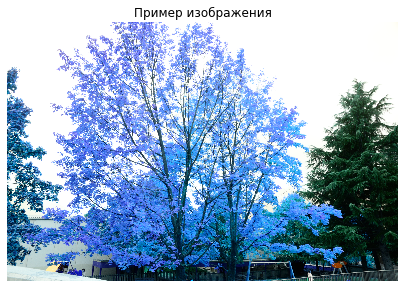

In [71]:
sample_image = cv2.imread(image_files[1])
plt.figure(figsize=(7, 7))
plt.title("Пример изображения")
plt.imshow(sample_image)
_ = plt.axis("off")
sample_image.shape

In [72]:
# Вспомогательные функции

def load_images(
    file_paths: List[str],
    image_shape: Optional[Tuple[int, int]] = None,
) -> np.ndarray:
  """Функция загрузки изображений."""
  image_list = []
  for file_path in tqdm(file_paths):
    image = cv2.imread(file_path)
    if image_shape is not None:
      image = cv2.resize(image, image_shape)
    image_list.append(image)    
  return np.array(image_list)


def jpeg_compress(
    image: np.ndarray,
    qf_value: Union[List[int], int],
  ) -> np.ndarray:
  """Функция JPEG-сжатия."""
  jpeg_image = image
  qf_value_ = qf_value
  if type(qf_value_) == int:
    qf_value_ = [qf_value_]
  for qf in qf_value_:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), qf]
    encoded_image = cv2.imencode('.jpg', jpeg_image, encode_param)[1]
    jpeg_image = Image.open(io.BytesIO(encoded_image))
  return np.array(jpeg_image)


def insert_image_block_to_another(
    source_image: np.ndarray,
    inserting_image: np.ndarray,
    binary_changes_mask: np.ndarray,
  ) -> np.ndarray:
  """Функция вставки блоков одного изображения в другое."""
  invert_bin_mask_of_changes = \
    np.logical_not(binary_changes_mask).astype(np.uint64)

  result_image = np.zeros_like(source_image)
  if len(source_image.shape) == 2:
    result_image = source_image * invert_bin_mask_of_changes + \
      inserting_image * binary_changes_mask
  else:
    channels = source_image.shape[2]
    for i in range(channels):
      result_image[:, :, i] = \
        source_image[:, :, i] * invert_bin_mask_of_changes + \
        inserting_image[:, :, i] * binary_changes_mask
  return result_image


def preprocess_input(image: np.ndarray, scale: float = 255.) -> np.ndarray:
    """Предобработка изобраэения."""
    im = image
    im = np.expand_dims(cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)[:, :, 0], -1)
    return im.astype(np.float32) / scale


def accuracy(true_map: np.ndarray, predicted_map: np.ndarray) -> float:
  """Мера точности."""
  return np.sum(true_map == predicted_map) / np.prod(true_map.shape)


def rmse(true_map: np.ndarray, predicted_map: np.ndarray) -> float:
  """Мера RMSE."""
  return np.sqrt(np.mean((true_map - predicted_map) ** 2))

In [73]:
# Загрузка изображений

images_array = load_images(image_files, image_shape=BASE_IMAGE_SHAPE)
images_array.shape

100%|██████████| 33/33 [00:16<00:00,  1.99it/s]


(33, 200, 200, 3)

## B0

### Задание 1

*Сгенерировать бинарную маску локальных изменений*

In [47]:
def generate_binary_local_changes_matrix(
    size: Tuple[int, int],
    num_blocks: int = 1,
) -> np.ndarray:
  """Функция генерация бинарной маски локальных изменений."""
  rows, cols = size
  matrix_of_changes = np.zeros(size)
  for _ in range(num_blocks):
    row_start = np.random.randint(rows / 4, rows / 2)
    row_end = np.random.randint(row_start, rows)
    col_start = np.random.randint(cols / 4, cols / 2)
    col_end = np.random.randint(col_start, cols)
    matrix_of_changes[row_start:row_end, col_start:col_end] = 1
  return matrix_of_changes

In [48]:
mask_of_changes = generate_binary_local_changes_matrix(BASE_IMAGE_SHAPE)

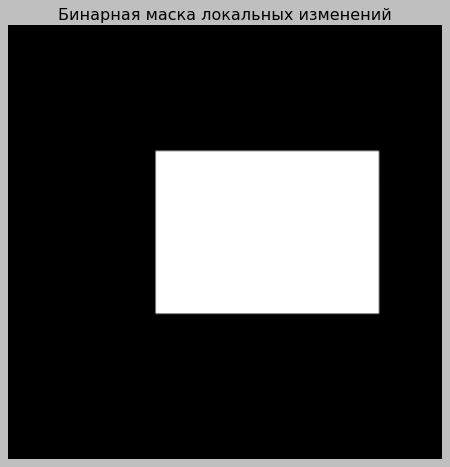

In [49]:
plt.figure(figsize=(7, 7))
plt.title("Бинарная маска локальных изменений")
plt.axis("off")
plt.imshow(mask_of_changes, cmap='gray')

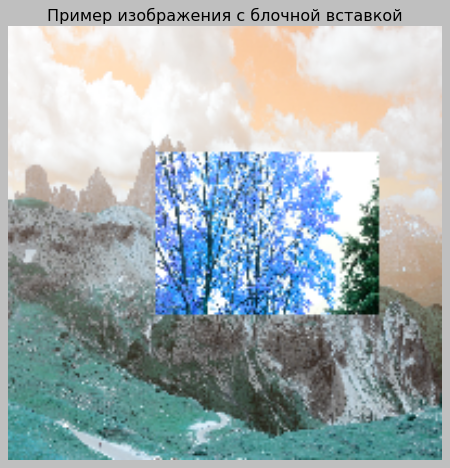

In [50]:
# Пример вставки одного изображения в другое
image_with_blocks_sample = \
  insert_image_block_to_another(
      images_array[0],
      images_array[1],
      mask_of_changes,
      )

plt.figure(figsize=(7, 7))
plt.title("Пример изображения c блочной вставкой")
plt.imshow(image_with_blocks_sample)
_ = plt.axis("off")

### Задание 2 

*Сгенерировать составные изображения из по-разному сжатых JPEG-изображений (одно произвольное сочетание $QF_{1.1}$, $QF_{1.2}$ и $QF_2$)*

In [51]:
def generate_splicing_images(
    images: np.ndarray,
    bin_mask_of_changes: np.ndarray,
    qf11: Union[int, List[int]],
    qf12: Union[int, List[int]],
    qf2: Union[int, List[int]],
) -> Optional[np.ndarray]:
  """Генерация составных изображений с разными JPEG-изображениями."""

  if len(images.shape) != 4:
    return None

  num_images, rows, cols, _ = images.shape

  if bin_mask_of_changes.shape[0] != rows \
    and bin_mask_of_changes.shape[1] != cols:
    return None

  splicing_image_list = []
  
  for i in tqdm(range(num_images)):
    current_image = images[i]
    another_image = images[i - 1]

    current_image_jpg = jpeg_compress(current_image, qf11)
    another_image_jpg = jpeg_compress(another_image, qf12)

    splicing_image = insert_image_block_to_another(
        current_image_jpg,
        another_image_jpg,
        bin_mask_of_changes,
    )

    splicing_image_jpg = jpeg_compress(splicing_image, qf2)

    splicing_image_list.append(splicing_image_jpg)

  return np.array(splicing_image_list)

In [52]:
# Реальное второе
splicing_images = generate_splicing_images(
    images_array,
    mask_of_changes,
    qf11=QF11,
    qf12=QF12,
    qf2=QF2,
  )


100%|██████████| 33/33 [00:17<00:00,  1.89it/s]


(33, 200, 200, 3)

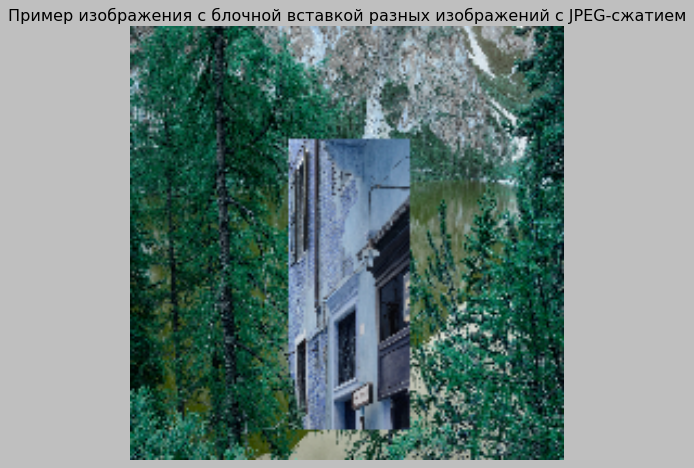

In [53]:
# Пример изображения
plt.figure(figsize=(7, 7))
plt.title("Пример изображения c блочной вставкой разных изображений с JPEG-сжатием")
plt.imshow(splicing_images[0])
_ = plt.axis("off")

### Задание 3 

*Автоматически сформировать маску изменений по одному произвольному ДКП-коэффициенту. При этом нельзя использовать информацию об истинных значениях $QF_{1.1}$, $QF_{1.2}$ и $QF_2$*

In [55]:
max_coeffs, _ = max_min_coefficient(
    quality_range=(50, 100),
    n_coeffs=15,
    zig_zag_order=True,
)

model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects=({
        'custom_softmax': custom_softmax_activation(max_coeffs),
        'custom_two_terms_loss_wrapper': custom_two_terms_loss_wrapper(
            max_coeffs, 0.8),
        'custom_mse': custom_mse_wrapper(max_coeffs)})
)

In [59]:
predicted_maps = []
predicted_labels = []

for i in tqdm(range(len(splicing_images))):
  splicing_image = splicing_images[i]
  img = preprocess_input(splicing_image)
  map, label = window_decision(
      img,
      model, 
      max_coeffs, 
      (64, 64, 1), 
      stride=BASE_STRIDE,
  )
  predicted_maps.append(map)
  predicted_labels.append(label)

100%|██████████| 33/33 [00:14<00:00,  2.30it/s]


(33, 200, 200, 3)

In [59]:
predicted_maps_array = np.array(predicted_maps)
predicted_label_array = np.array(predicted_labels)

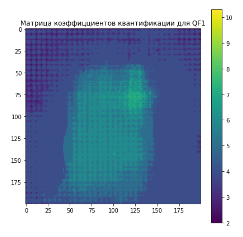

In [95]:

plt.figure(figsize=(4, 4))
plt.title("Матрица коэффицциентов квантификации для QF1")
plt.imshow(predicted_maps_array[0][:, :, 0])
plt.colorbar()

In [97]:
predicted_label_array[0, :, 0]

array([3., 2., 2., ..., 4., 3., 4.])


### Задание 4

*Выбрать меру оценивания качества построения маски изменений и произвести оценивание*

In [ ]:
def map_segmentation(
    map: np.ndarray, 
    segment_number: int = 2,
) -> np.ndarray:
  """Сегментация маски."""
  flatten_map = map.flatten()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret, label, center = cv2.kmeans(np.float32(flatten_map), segment_number, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  return label.reshape(map.shape)

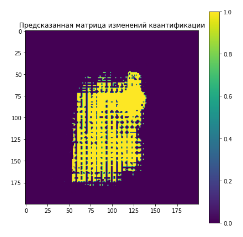

In [99]:
sample_segmentation_map = map_segmentation(predicted_maps_array[0][:, :, 0])
plt.figure(figsize=(4, 4))
plt.title("Предсказанная матрица изменений квантификации")
plt.imshow(sample_segmentation_map)
plt.colorbar()

In [100]:
print(f"""
RMSE = {rmse(mask_of_changes, sample_segmentation_map)}
Accuracy = {accuracy(mask_of_changes, sample_segmentation_map)}
""")

RMSE = 0.30784512636154837
Accuracy = 0.867168


In [ ]:
def map_estimation(
    true_map: np.ndarray,
    predicted_map: np.ndarray,
) -> Tuple[float, float]:
  """Оценка предсказания для данной матрицы изменений."""
  segmented_map = map_segmentation(predicted_map)
  if segmented_map[0, 0] == 1:
    segmented_map[segmented_map == 1] = 2
    segmented_map[segmented_map == 0] = 1
    segmented_map[segmented_map == 2] = 0
  rmse_value = rmse(true_map, segmented_map)
  accuracy_value = accuracy(true_map, segmented_map)
  return rmse, accuracy_value

In [ ]:
rmse_values = []
accuracy_values = []
for i in range(len(predicted_maps_array)):
  map_qf1 = predicted_maps_array[i][:, :, 0]
  rmse_value, accuracy_value = map_estimation(mask_of_changes, map_qf1)
  rmse_values.append(rmse_value)
  accuracy_values.append(accuracy_value)

In [101]:
print(f"Среднее RMSE: {np.mean(rmse_values)}")
print(f"Среднее Accuracy: {np.mean(accuracy_values)}")

Среднее RMSE: 0.4723826572451271
Среднее Accuracy: 0.7178457241907854
